In [1]:
import platform
from pathlib import Path

import os
import subprocess
import time

import numpy as np
import scipy
from scipy import optimize
import pandas as pd # I added as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from addict import Dict
import json

# Temporary files for simulation objects
import tempfile
tempfile.tempdir = os.path.join(Path.home())

# IPython
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image
from ipywidgets import interact, interactive
import ipywidgets as widgets

import copy
from biopandas.pdb import PandasPdb


# Depth of charged atoms in protein assemblies

In [2]:
prot_folders = os.listdir('pqr_structure_files')
prot_folders.sort()
prot_folders.remove('edtsurf_notes.txt')

In [3]:
dfs_pqr = {} # .pqr file (protein structure)
dfs_dep = {} # Depths of each atom in the pqr file beneath the VdW surface

for f in prot_folders:
    if f[:3] == 'lys':
        pass
    else:
        # In this format, BioPandas loads the partial charge into the occupancy column
        dfs_pqr[f] = PandasPdb().read_pdb('./pqr_structure_files/' + f + '/pqr.pqr')
        dfs_dep[f] = pd.read_fwf('./pqr_structure_files/' + f + '/pqr_atom.dep')

In [4]:
charged_ox = ['OXT', 'OE1', 'OE2', 'OD1', 'OD2'] # 'SG'
dfs_negative_atoms = {}

for f in prot_folders:
    if f[:3] == 'lys':
        pass
    else:
    
        temp = []
        i_ind = 0
        df = dfs_pqr[f].df['ATOM'].copy()
        
        for i, cont in df.iterrows():
            if (cont['residue_name'] == 'GLU' and cont['atom_name'] == 'OE1') or (cont['residue_name'] == 'ASP' and cont['atom_name'] == 'OD1') or (cont['atom_name'] == 'OXT'):
                temp.append([cont['residue_name'], cont['atom_number'], cont['atom_name']])
            else:
                pass
        
        dfs_negative_atoms[f] = pd.DataFrame(temp, columns=['res_name', 'atom_num', 'atom_name'])           
        for i, icont in dfs_negative_atoms[f].iterrows():
            dfs_negative_atoms[f].at[i, 'depth'] = dfs_dep[f].loc[dfs_dep[f]['atom#'] == icont['atom_num'], 'depth'].iloc[0]

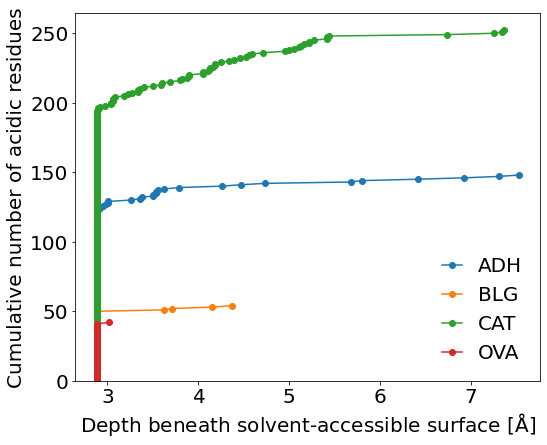

In [7]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6.5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Depth beneath solvent-accessible surface [$\rm{\AA}$]')
ax.set_ylabel('Cumulative number of acidic residues')

num_surf = []
total_neg = []
x_thresh = 3.2

for f in prot_folders:
    if f[:3] != 'lys':
        depths = list(dfs_negative_atoms[f]['depth'])
        depths.sort()
        threshold = next((x for x in depths if x > x_thresh), depths[-1])
        num_surf.append(depths.index(threshold) + 1)
        total_neg.append(len(depths))
        
        p = np.arange(len(depths)) + 1.0
        ax.plot(depths, p, linestyle='-', marker='o', label=f[:3].upper())

# ax.axvline(x=x_thresh, linestyle='--', color='black')
ax.legend(handlelength=1, frameon=False)
plt.tight_layout()

ax.set_ylim(0, None)
fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth.png', bbox_inches='tight', dpi=300)
# fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth.pdf', bbox_inches='tight')

# Depth of charged atoms in monomers

In [60]:
parent_dir = './pqr_structure_files_monomers'
prot_folders = os.listdir(parent_dir)
prot_folders.sort()
prot_folders = [f for f in prot_folders if '.sh' not in f]

In [61]:
dfs_pqr = {} # .pqr file (protein structure)
dfs_dep = {} # Depths of each atom in the pqr file beneath the VdW surface

for f in prot_folders:
    # In this format, BioPandas loads the partial charge into the occupancy column
    dfs_pqr[f] = PandasPdb().read_pdb(f'./{parent_dir}/{f}/pqr.pqr')
    dfs_dep[f] = pd.read_fwf(f'./{parent_dir}/{f}/pqr_atom.dep')

In [62]:
charged_ox = ['OXT', 'OE1', 'OE2', 'OD1', 'OD2'] # 'SG'
dfs_negative_atoms_mono = {}

for f in prot_folders:
    temp = []
    i_ind = 0
    df = dfs_pqr[f].df['ATOM'].copy()

    for i, cont in df.iterrows():
        if (cont['residue_name'] == 'GLU' and cont['atom_name'] == 'OE1') or (cont['residue_name'] == 'ASP' and cont['atom_name'] == 'OD1') or (cont['atom_name'] == 'OXT'):
            temp.append([cont['residue_name'], cont['atom_number'], cont['atom_name']])
        else:
            pass

    dfs_negative_atoms_mono[f] = pd.DataFrame(temp, columns=['res_name', 'atom_num', 'atom_name'])           
    for i, icont in dfs_negative_atoms_mono[f].iterrows():
        dfs_negative_atoms_mono[f].at[i, 'depth'] = dfs_dep[f].loc[dfs_dep[f]['atom#'] == icont['atom_num'], 'depth'].iloc[0]

(0.0, 66.1)

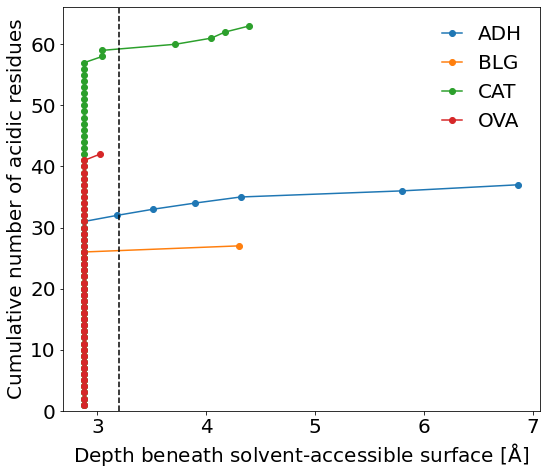

In [63]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Depth beneath solvent-accessible surface [$\rm{\AA}$]')
ax.set_ylabel('Cumulative number of acidic residues')

num_surf = []
total_neg = []
x_thresh = 3.2

for f in prot_folders:
    if f[:3] != 'lys':
        depths = list(dfs_negative_atoms_mono[f]['depth'])
        depths.sort()
        threshold = next((x for x in depths if x > x_thresh), depths[-1])
        num_surf.append(depths.index(threshold) + 1)
        total_neg.append(len(depths))
        
        p = np.arange(len(depths)) + 1.0
        ax.plot(depths, p, linestyle='-', marker='o', label=f[:3].upper())

ax.axvline(x=x_thresh, linestyle='--', color='black')
ax.legend(handlelength=1, frameon=False)
plt.tight_layout()

ax.set_ylim(0, None)
# fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth_monomers.png', bbox_inches='tight', dpi=300)
# fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth_monomers.pdf', bbox_inches='tight')

# Protein assemblies and monomers

In [76]:
n_monomers = {
    'adh_pH_7':4,
    'blg_pH_7':2,
    'cat_pH_7':4,
    'ova_pH_7':1,
}

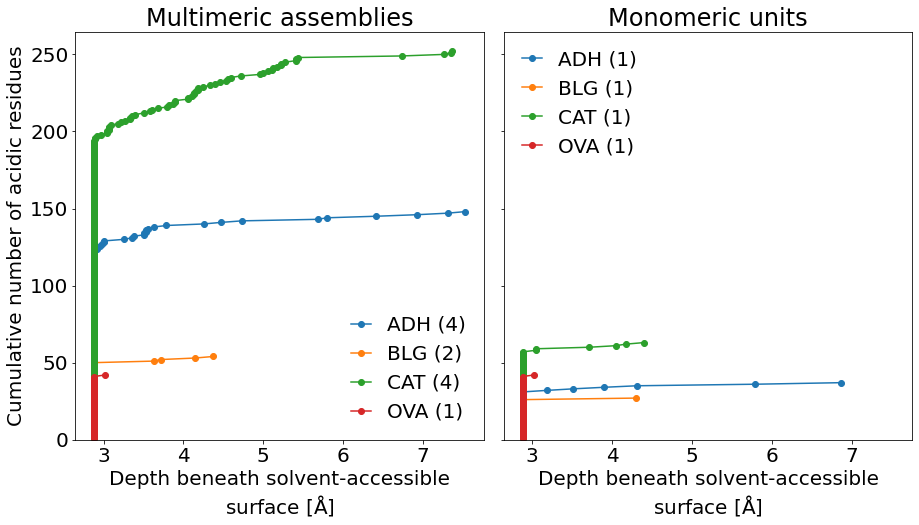

In [82]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(15, 7.5, forward=True)
fig.patch.set_alpha(1.0)
plt.subplots_adjust(wspace=0.05)
ax[0].set_ylabel('Cumulative number of acidic residues')
for i in range(2):
    ax[i].set_xlabel('Depth beneath solvent-accessible' + '\n' + r'surface [$\rm{\AA}$]')

ax[0].set_title('Multimeric assemblies')
ax[1].set_title('Monomeric units')

for f in prot_folders:
    if f[:3] != 'lys':
        depths = list(dfs_negative_atoms[f]['depth'])
        depths.sort()        
        p = np.arange(len(depths)) + 1.0
        n = n_monomers[f]
        ax[0].plot(depths, p, linestyle='-', marker='o', label=f'{f[:3].upper()} ({n})')

for f in prot_folders:
    if f[:3] != 'lys':
        depths = list(dfs_negative_atoms_mono[f]['depth'])
        depths.sort()        
        p = np.arange(len(depths)) + 1.0
        ax[1].plot(depths, p, linestyle='-', marker='o', label=f'{f[:3].upper()} (1)')
        
ax[0].legend(handlelength=1, frameon=False)
ax[1].legend(handlelength=1, frameon=False, loc='upper left')

ax[0].set_ylim(0, None)

fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth_assemblies_and_monomers.png', bbox_inches='tight', dpi=300)
fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth_assemblies_and_monomers.pdf', bbox_inches='tight')